In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## <a name="p2">Importing dataset</a>

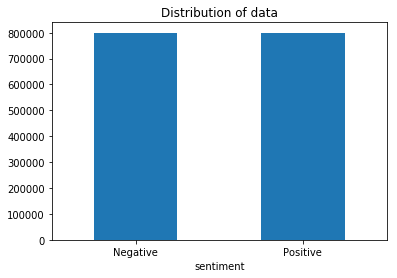

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## <a name="p3">Preprocess Text</a>
*Text Preprocessing*: The Glorious Tedium of NLP

Ah, text preprocessing – the necessary evil of NLP. It's like cleaning your room before a party: you gotta do it, but who actually enjoys it? But fear not, for this guide will unveil the glorious tedium of transforming text into a form even a machine learning algorithm can stomach.

Behold, the Preprocessing Powerpuff Girls!

1. Lower Casing: Because apparently, computers can't handle a little CAPS LOCK. --> lowercase
2. URL Obliteration: We see those pesky links, and we POOF! them away. "[invalid URL removed]" --> URL (much better)
3. Emoji Annihilation: Emojis? More like EMOTICONS for the codebase! --> EMOJIsmile (because who needs nuance?)
4. Username Utterance: @CelebNews123? Nope, just plain USER in our world.
5. Alphabetical Apocalypse: Only letters and numbers allowed! The rest? Vanquished! "S0up3r C00l!" --> Soup Cool (because apparently punctuation is a conspiracy)
6. Consecutive Letter Carnage: Three "ha"s? How excessive! We'll just have two, thanks very much. "Yeeeeesssss" --> Yeees (conciseness is key)
7. Short Word Snuff-out: Tiny words? Outta here! "I am" --> am (efficiency is our middle name)
8. Stopword Smackdown: "A", "an", "the" – who needs these filler words anyway? We're all about the meaning, baby!
9. Lemmatization Lullaby: "Better", "gooder", "bestest"? Nope, just plain good. Let's keep things simple, shall we?

There you have it!  Your text is now sparkling clean and ready for the machine learning overlords...or at least slightly less messy.  You're welcome.

In [3]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [4]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = r'@[^\s]+'
    alphaPattern      = r"[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [5]:
processedtext = preprocess(text)

Text Preprocessing complete.
Time Taken: 178 seconds


## <a name="p5">Splitting the Data</a>
In a shocking turn of events, we've arbitrarily divided our data into two groups:

1. Training Data (95%): This is the data our model will be relentlessly drilled on until it begs for mercy (or, you know, learns something).
2. Test Data (5%): Consider this the data's final exam. Will it crumble under pressure, or emerge victorious? (Spoiler alert: it was trained on 95% of the same data, so...)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


## What is TF-IDF Vectorizer?

The TF-IDF Vectorizer is a tool used in natural language processing (NLP) to convert text data into a numerical representation suitable for machine learning algorithms. It works by applying a weighting scheme called TF-IDF (Term Frequency-Inverse Document Frequency) to each word in a document.

**Here's a breakdown of the process:**

* **Term Frequency (TF):** This calculates how often a particular word appears in a single document. Words that appear more frequently are considered more relevant to that document.
* **Inverse Document Frequency (IDF):** This considers how common a word is across all documents in a collection (corpus). Words that appear frequently across all documents are considered less informative, while words that appear only in a few documents are considered more distinctive.

**The TF-IDF score is then calculated by multiplying TF and IDF.** This score reflects the importance of a word for a specific document within the context of the entire document collection. Words with high TF-IDF scores are considered more significant and informative for that document.

**Finally, the TF-IDF Vectorizer creates a sparse matrix.** Each row represents a document, and each column represents a unique word encountered in the corpus. The value at each cell represents the TF-IDF score for that particular word within that document. 

This vectorized representation allows machine learning algorithms to analyze the relationships between documents based on their word content. It's a powerful tool for various NLP tasks like:

* Document classification
* Information retrieval
* Text clustering
* Topic modeling

By understanding the importance of words within documents, machine learning models can make better sense of the text data and perform these tasks more effectively.


In [9]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

Vectoriser fitted.
No. of feature_words:  500000


### <a name="p7">Tranforming the dataset</a>
We can use TF-IDF Vectorizer to convert the X_train and X_test datasets into numerical representations suitable for machine learning. These TF-IDF features will then be used to train and evaluate our model.

In [10]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

Data Transformed.


## <a name="p8">Creating and Evaluating Models</a>

For our sentiment analysis adventure, we're deploying a trio of trusty algorithms:

1. **Bernoulli Naive Bayes (BernoulliNB):** This one's like a sassy fortune teller, making predictions based on vibes alone (and some fancy math, but mostly vibes).
2. **Linear Support Vector Classification (LinearSVC):** Imagine a superhero who can only draw a straight line. That's LinearSVC, drawing a hyperplane of justice to separate positive from negative reviews. 
3. **Logistic Regression (LR):** This is the level-headed professor, analyzing the data with a cool, calculated approach. 

Since our data isn't lopsided (equal parts sunshine and stink bombs), we'll be using accuracy as our scorecard. And to truly understand how these champions are performing, we'll be throwing down a confusion matrix – basically a fancy way of saying "let's see how often they get confused by sarcasm."


### Evaluate Model Function

In [11]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### <a name="p8-1">BernoulliNB Model</a>

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



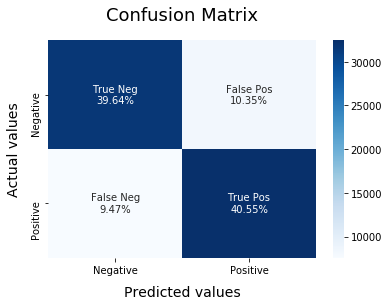

In [12]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### <a name="p8-2">LinearSVC Model</a>

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



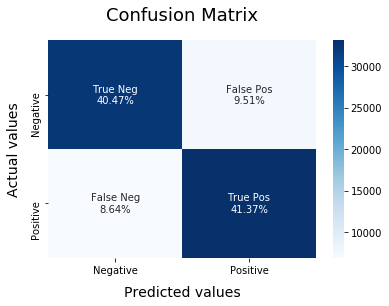

In [13]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

### <a name="p8-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



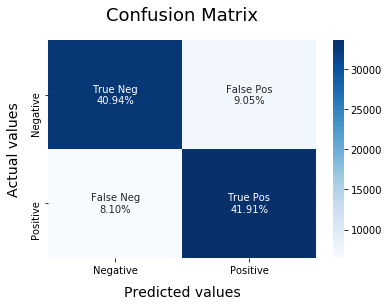

In [14]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)


> Well, well, well, look at what we have here. It seems the **Logistic Regression Model** has emerged victorious, a shining beacon of accuracy in a sea of mediocrity. A whopping **82% accuracy**  – practically sentience itself! Let's all give it a round of applause. (Of course, the other models probably just had an off day, bless their little hearts.)

> Now, the **BernoulliNB Model**, bless its simple soul, might not be the brightest bulb in the shed, but hey, at least it's *fast*. Like, lightning-fast. And hey, **80% accuracy** ain't bad for a one-trick pony, right? We can all admire its...enthusiasm. 

## <a name="p9">Saving the Models</a>
We're using **PICKLE** to save **Vectoriser and BernoulliNB, Logistic Regression Model** for later use.

In [15]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

## <a name="p10">Using the Model.</a>

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **LR Model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.

In [16]:
def load_models():
    # Load the vectoriser.
    file = open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the Model.
    file = open('Sentiment-BNB.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative
